# Step One Photon Number Discrimination
* Determine the height thresholds for 2 level discrminator
* Obtain area histogram of traces
* Use area histogram to categorise photon number in traces

In [2]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')

import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pickle
from multiprocess import Pool

import seaborn

import heralded_pulses_analysis as hpa
import thres_poiss
import thres
import pulse_utils as pu
reload(pu)

<module 'pulse_utils' from '/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode/pulse_utils.pyc'>

In [4]:
# Imports CW traces
directories = ['/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more_more/']
results_directory = './'
filelist=[]
for directory_name in directories:
    subfilelist = np.array(glob.glob(directory_name + '*.trc'))
    filelist.extend(subfilelist)
filelist = np.sort(np.array(filelist))
print len(filelist)

400000


# Get Approximate Height Threshold
Estimate threshold height to discriminate between electrical noise and photodetection events.

Gets maximum height of pulses, histograms the heights. 

Fit the distributions to a model to find the minimum crossing point between the distributions.

The resolution of this distribution will not be optimal due to the presence of partial pulses at the edges.

In [5]:
sample_size = int(0.1*len(filelist)) # number of samples to obtain height threshold from

In [6]:
# max_heights = np.array([hpa.max_height(f) for f in tqdm.tqdm(filelist[:sample_size])])
max_heights = np.array(Pool(24).map(hpa.max_height, tqdm.tqdm(filelist[:sample_size])))

100%|██████████| 40000/40000 [00:03<00:00, 12286.69it/s]


In [7]:
bins = 150

In [8]:
height_distribution = np.histogram(max_heights, bins)

In [9]:
height_th_approx = thres_poiss.thresholds_N(height_distribution, 
                                            min_peak_sep=0.01, 
                                            weighted=True)
print height_th_approx

[0.0078042049269024276]


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


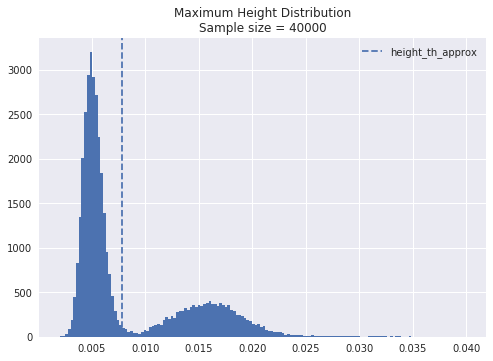

In [10]:
plt.figure()
plt.title('Maximum Height Distribution\nSample size = {}'.format(sample_size))
plt.bar(height_distribution[1][:-1],
        height_distribution[0], 
        width = np.diff(height_distribution[1])[0],
        align='center')
plt.axvline(height_th_approx, label='height_th_approx', linestyle='--')
plt.legend()
plt.show()

# Get Height Threshold (excluding partial pulses)
The maximum height of pulses at the edge of the acquisition window do not report the peak photodetection signal - they are obscured.

We use the approximate height obtained to initialise a two level discriminator.

The discriminator has 3 inputs:
* high_th: the level crossing that identifies the signal as a photodetection event
* low_th: the level crossing that turns the discriminator logic off
* offset: the number of data points that the discriminator window extends, in order to improve the signal to noise ratio

We use param_extr to calculate these values, 
(within discriminated windows, while ignoring partial traces)
* max height 
* rms 
* absolute area 

In [11]:
# Calculate offset value as a function of points
time_vector = pu.time_vector(filelist[0])
dt = np.diff(time_vector)[0]
offset = int(1300e-9/dt)
print offset

650


In [13]:
# trace_parameters_approx = np.array([hpa.param_extr(f,
#                                    high_th = height_th_approx,
#                                    low_th = 0,
#                                    offset = offset)
#                    for f in tqdm.tqdm(filelist[:sample_size])])
trace_parameters_approx = np.array(Pool(24).map(lambda f: hpa.param_extr(f,
                                   high_th = height_th_approx,
                                   low_th = 0,
                                   offset = offset),
                                  tqdm.tqdm(filelist[:sample_size])))

100%|██████████| 40000/40000 [00:08<00:00, 4547.02it/s] 


In [14]:
max_heights_discriminated = trace_parameters_approx['height']

In [15]:
bins = 150
height_distribution_discriminated = np.histogram(max_heights_discriminated, bins)

In [16]:
reload(thres_poiss)

result_height =  thres_poiss.gauss_fit_interp(height_distribution_discriminated, 
                                  min_peak_sep=0.01,
                                  weighted=True)

height_th = thres_poiss.thresholds_N(height_distribution_discriminated, 
                                            min_peak_sep=0.01, 
                                            weighted=True)
height_th = height_th[0]
height_th

0.0079408483085594457

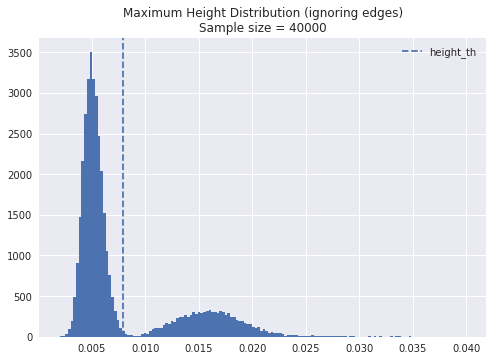

In [17]:
plt.figure()
plt.title('Maximum Height Distribution (ignoring edges)\nSample size = {}'.format(sample_size))
plt.bar(height_distribution_discriminated[1][:-1],
        height_distribution_discriminated[0], 
        width = np.diff(height_distribution_discriminated[1])[0],
        align='center')
plt.axvline(height_th, label='height_th', linestyle='--')
plt.legend()
plt.show()

In [18]:
def histogram(nphisto):
    bins = nphisto[1][:-1]
    bins = bins + np.diff(bins)[0]/2
    frequencies =  nphisto[0]
    return frequencies, bins

In [19]:
frequencies,bins = histogram(height_distribution_discriminated)
comps = result_height.eval_components(x=bins)

In [20]:
np.savetxt('pnr_height.dat',histogram(height_distribution_discriminated))
np.savetxt('g0_component.dat',comps['g0_'])
np.savetxt('g1_component.dat',comps['g1_'])
with open('pnr_height_readme.dat','a+') as fp:
    fp.write('height_th = {}\n samples = {}'.format(height_th,sample_size))
fp.close()

# Calculate trace parameters with height threshold (obtained excluding partial pulses)
* Computes trace parameters for ALL traces
* Speeds up tasks with multiprocessing

In [21]:
# Import/Set discriminator settings
# if os.path.isfile(results_directory + 'disc_settings.dat'):
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)

In [5]:
# Manually set height_th
height_th = 0.007940936436562001

In [22]:
# saves discriminator characteristics
np.savetxt(results_directory + 'disc_settings.dat', [height_th, offset],header='height_th\toffset')

In [23]:
print height_th, offset

0.00794093643656 650


In [24]:
tasks = tqdm.tqdm(filelist)
def param_extr_poolable(f):
    """poolable version of parameter extractor"""
    return hpa.param_extr(f,
                   high_th = height_th,
                   low_th = 0,
                   offset = offset)

  0%|          | 0/400000 [00:00<?, ?it/s]

In [6]:
reload(hpa)
if os.path.isfile(results_directory + 'trace_params.dat'):
    trace_parameters = np.genfromtxt(results_directory + 'trace_params.dat', names=True)
else:
    trace_parameters = np.array(Pool(24).map(param_extr_poolable, tasks))
# trace_parameters = np.array(Pool(24).map(param_extr_poolable, tasks))

In [7]:
area = trace_parameters['area_win']

In [27]:
# %matplotlib notebook
# plt.hist(height,200);

# Fit Area Distribution
* Threshold (th01) between n=0, n=1 determined by seeking the minimum between the two distributions.
* N >= 1 distributions fitted with Gaussian multiplied by Poisson coefficients
* N=1 distribution is selected to be within 2 sigmas of its distribution.
* N=2 distribution selected to be within th12 and th23

In [8]:
bins = 200
area_distribution = np.histogram(area, bins) 

est peak pos = [  1.55496654   5.65442377  10.88476576  14.56014122]
est peak hts = [ 170 5226  418   57]
th01 = 2.75653158938
poissonian probs from n=1,2...= [0.19970690196067434, 0.02582796623890183, 0.0022268762654623158]


<IPython.core.display.Javascript object>


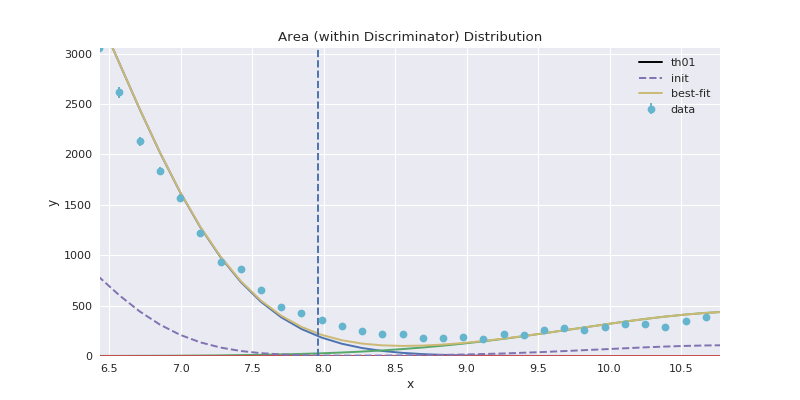

[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_'))
[[Variables]]
    n_bar:          0.25865872 (init= 0.2)
    A:              56248.7552 (init= 15678)
    Delta_E:        50.6311129 (init= 3.675375)
    sigma_p:        0.91656977 (init= 0.6752372)
    g1_center:      5.63692591 (init= 5.654424)
    g2_center:      11.0597136 (init= 10.88477)
    g3_center:      16.1250003 (init= 14.56014)
    g1_amplitude:   11233.2646  == 'A * exp(-n_bar) * n_bar**1 / factorial(1)'
    g2_amplitude:   1452.79095  == 'A * exp(-n_bar) * n_bar**2 / factorial(2)'
    g3_amplitude:   125.259017  == 'A * exp(-n_bar) * n_bar**3 / factorial(3)'
    g1_sigma:       0.91656977  == 'sigma_p * sqrt(1)'
    g2_sigma:       1.29622541  == 'sigma_p * sqrt(2)'
    g3_sigma:       1.58754542  == 'sigma_p * sqrt(3)'



In [48]:
%matplotlib notebook
reload(thres)
result = thres.gauss_fit_poiss_ph_region(area_distribution,
                                          min_peak_sep=3, 
                                          threshold=5e-3, 
                                          weighted=True,
                                          plot=True)
result.plot_fit()
plt.title('Area (within Discriminator) Distribution')
plt.ylim(0,8000)
plt.xlim(0,16)
plt.show()

In [35]:
result.params.valuesdict()['n_bar']

0.25865872421362579

In [30]:
print result.best_values['g2_center']/result.best_values['g1_center']
print result.best_values['g3_center']/result.best_values['g2_center']
# 8.55/result.best_values['g1_center']

1.96201152484
1.45799438425


In [31]:
th01 = 2.75653158938
# th01 = 2.45252376071

In [49]:
reload(thres)
thresholds = thres.thresholds_N(area_distribution,
                              min_peak_sep=3, 
                              threshold=5e-3, 
                              weighted=True)
print thresholds
ax = plt.gca(); map(lambda t: ax.axvline(t, linestyle='--'),thresholds); #plot thresholds in area distribution

est peak pos = [  1.55496654   5.65442377  10.88476576  14.56014122]
est peak hts = [ 170 5226  418   57]
th01 = 2.75653158938
poissonian probs from n=1,2...= [0.19970690196067434, 0.02582796623890183, 0.0022268762654623158]
at threshold 7.96020232006 between 5.63692591162 and 11.0597136033:
prob signal lost = 0.00839710546365
prob noise enters = 0.00562635969086
at threshold 13.4174296449 between 11.0597136033 and 16.125000325:
prob signal lost = 0.0440499043631
prob noise enters = 0.0344626587838
[7.9602023200581318, 13.417429644926635]


In [33]:
frequencies ,bins = histogram(area_distribution)
comps = result.eval_components(x=bins)

In [34]:
np.savetxt('pnr_area_disc.dat',histogram(area_distribution))
np.savetxt('g1_area_component.dat',comps['g1_'])
np.savetxt('g2_area_component.dat',comps['g2_'])
np.savetxt('g3_area_component.dat',comps['g3_'])
with open('pnr_area_readme.dat','a+') as fp:
    fp.write('a_th01 = {}\n a_th12 = {}\n a_th23 = {}\nsamples = {}'.format(th01,thresholds[0],thresholds[1],sample_size))
fp.close()

In [35]:
bins = 200
area_above_threshold = trace_parameters['area']
area_above_threshold_distribution = np.histogram(area_above_threshold, bins) 
frequencies, bins = histogram(area_above_threshold_distribution)
np.savetxt('pnr_area_above_th.dat',histogram(area_above_threshold_distribution))

# Photon Number Masks
* creates mask for photon numbers

In [36]:
# th_areas = np.loadtxt(results_directory+'th_areas_from_min_overlap.dat')
# [th01, th12, th23] = th_areas

In [37]:
mask_0ph = (area < th01)

In [38]:
# single photon mask: 
# within 2 std deviations of mean single-photon area to exclude outliers corresponding to more false positives 
mask_1ph = (area > result.best_values['g1_center']-2*result.best_values['g1_sigma'])&\
           (area < result.best_values['g1_center']+2*result.best_values['g1_sigma'])
# two photon mask:
# within thresholds corresponding to minimal overlap between n=1 and n=3 photons
mask_2ph = (area > thresholds[0])&(area < thresholds[1])
# mask_2ph = (area > result.best_values['g2_center']-2*result.best_values['g2_sigma'])&\
#            (area < result.best_values['g2_center']+2*result.best_values['g2_sigma'])
# mask_2ph = (area >= 7.95798869853)&(area <= 14)
# mask_2ph = (area>th12)&(area<th23)

In [39]:
print sum(mask_2ph)

10706


# Save filelists and fit results

In [40]:
# saves filelist of n = 0, 1, 2 photons
hpa.append2file(results_directory + 'filelist_zero_photon.dat',"\n".join(filelist[mask_0ph]))
hpa.append2file(results_directory + 'filelist_single_photon.dat',"\n".join(filelist[mask_1ph]))
hpa.append2file(results_directory + 'filelist_two_photon.dat',"\n".join(filelist[mask_2ph]))

In [41]:
# saves fit results of area distribution
f = open(results_directory + 'area_distribution_lmfit_result.dat','wb')
pickle.dump(result,f)
f.close()

In [42]:
# saves thresholds(point of minimal overlap) between number distributions 
th_areas_from_min_overlap = np.array(np.insert(thresholds,0,th01))
np.savetxt(results_directory+'th_areas_from_min_overlap.dat',th_areas_from_min_overlap,header='\t'.join(['th01,th12,th23']))

In [43]:
# saves whole filelist and trace parameters for future reference
hpa.append2file(results_directory + 'filelist.dat',"\n".join(filelist))
np.savetxt(results_directory + 'trace_params.dat',trace_parameters,header="\t".join(trace_parameters.dtype.names))

In [44]:
# saves fit result of height distribution
g = open(results_directory + 'height_distribution_lmfit_result_height_th_{}.dat'.format(height_th),'wb')
pickle.dump(result_height,g)
g.close()

# Calculate RMS noise of n=0 traces

In [45]:
a = np.genfromtxt(results_directory + 'filelist_zero_photon.dat', delimiter='\n',dtype='string')

In [46]:
trace_parameters.dtype.names

('area_win', 'area', 'height', 'rms')

In [47]:
rms = np.mean(trace_parameters['rms'][mask_0ph])
np.savetxt(results_directory + 'rms.dat', 
           [rms],
           header='rms')
print rms

0.00180058629476
